# Feature and Structure Independence

### Libs

In [1]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time
import math

## Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 
import scipy.stats as stats
from scipy.stats import wasserstein_distance

## Data Wrangling
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

Using TensorFlow backend.


### Supporting Function

In [2]:
## supporting functions
from support.preprocessing import sort_adj, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, pad_attr, unpad_attr, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single_features, generate_manifold_features
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

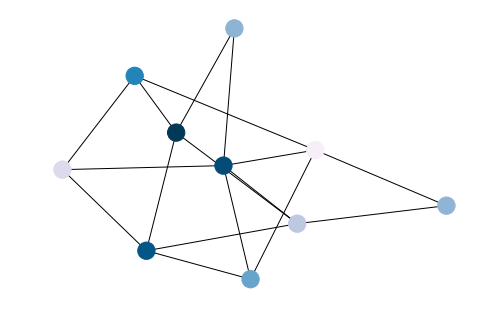

In [3]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [88]:
def generate_features(dataArgs, g, n, p):
    
        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "norm_degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f) / (max(f)+1)
                f = np.reshape(f, (f.shape[-1],1))
                
        
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f+1) / (dataArgs["n_max"]+1)
                f = np.reshape(f, (f.shape[-1],1))
    
                
        if dataArgs["feature_dependence"] == "uniform":
            if dataArgs["n_features"] == 1:
                
                f = np.ones((len(g)))  
                f = f * np.random.rand()
                f = np.reshape(f, (f.shape[-1],1))
                
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n , 1)) * p
                
        return f

In [89]:
def prepare_in_out(diag_offset, A_shape, F_shape):

    if diag_offset == 0:  # matrix input
        return (F_shape[1], A_shape[0]), (F_shape[1], A_shape[0])


In [90]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    
    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

            
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
                     
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adj(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        
        
        ## Generate / Load Node Features ______________________________________________
        f = generate_features(dataArgs, g, n, p)
        
        ## pad features with zeroes
        f = pad_attr(f, dataArgs)

        
        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed


    ## Input and Output Size ___________________________________________________________

    input_shape, output_shape = prepare_in_out(dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]), F.shape)
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G, F, input_shape,output_shape
    
dataArgs = {"n_graphs": 100, "n_max": 16, "feature_dependence": "uniform", "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True, "n_features": 1}  #"diag_offset" - 1 == full adjacency
G, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: uniform


input_shape: (16, 136) , output_shape: (16, 136)


# beta-VAE Model

In [18]:
## libs
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from sklearn.model_selection import train_test_split


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon



    def __init__(self, modelArgs, trainArgs, fg_train, f_train, g_train, fg_test, f_test, g_test):

        ## MODEL ______________________________________________________________
        
        
        ## 1.1) build attr encoder model
        attr_input = Input(shape= (modelArgs["input_shape"][0],), name='attr_input')
        x1 = Dense(12, activation='relu')(attr_input)
        x1 = Dense(8, activation='relu')(x1)        
        
        ## 1.2) build topol encoder model
        topol_input = Input(shape= (modelArgs["input_shape"][1],), name='topol_input')
        x2 = Dense(64, activation='relu')(topol_input)
        x2 = Dense(32, activation='relu')(x2)
        x2 = Dense(8, activation='relu')(x2)
        
        
        encoder_combined = concatenate([x1, x2])
        z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(encoder_combined)
        z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(encoder_combined)
        
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])
        
        latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
        
        ## 2.1) build attr decoder model
        y1 = Dense(8, activation='relu')(latent_inputs)
        y1 = Dense(32, activation='relu')(y1)
        y1 = Dense(64, activation='relu')(y1)
        attr_output = Dense(modelArgs["output_shape"][0], activation='sigmoid')(y1)
        
        ## 2.2) build topol decoder model
        y2 = Dense(8, activation='relu')(latent_inputs)
        y2 = Dense(32, activation='relu')(y2)
        y2 = Dense(64, activation='relu')(y2)
        topol_output = Dense(modelArgs["output_shape"][1], activation='sigmoid')(y2)
    


    
        ## INSTANTIATE___________________________________

        ## 1) instantiate topol encoder model
        attr_topol_encoder = Model([attr_input, topol_input], [z_mean, z_log_var, z], name='attr_topol_encoder')
        attr_topol_encoder.summary()

        ## 2) instantiate topology decoder model
        attr_topol_decoder = Model(latent_inputs, [attr_output, topol_output], name='attr_topol_decoder')
        attr_topol_decoder.summary()
        
        ## 3) instantiate VAE model
        attr_topol_outputs = attr_topol_decoder(attr_topol_encoder([attr_input, topol_input])[2])
        vae = Model([attr_input, topol_input], attr_topol_outputs, name='vae')

    

        ## LOSS FUNCTIONS ______________________________________
        
        def loss_func(y_true, y_pred):
            
            y_true_attr = y_true[0]
            y_pred_attr = y_pred[0]
            
            y_true_topol = y_true[1]
            y_pred_topol = y_pred[1]
            

            ## ATTR RECONSTRUCTION LOSS_______________________            
            ## mean squared error
            attr_reconstruction_loss = mse(K.flatten(y_true_attr), K.flatten(y_pred_attr))
            attr_reconstruction_loss *= modelArgs["input_shape"][0]
            
            ## TOPOL RECONSTRUCTION LOSS_______________________
            ## binary cross-entropy
            topol_reconstruction_loss = binary_crossentropy(K.flatten(y_true_topol), K.flatten(y_pred_topol))
            topol_reconstruction_loss *= modelArgs["input_shape"][0]
                     
            ## KL LOSS _____________________________________________
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(trainArgs["loss_weights"][0] * attr_reconstruction_loss + trainArgs["loss_weights"][1] * topol_reconstruction_loss + trainArgs["loss_weights"][2] * kl_loss)
            
            return loss
        
        
    
    
    
        ## MODEL COMPILE______________________________________________
        
        #vae.compile(optimizer='adam', loss={"attr_decoder": attr_loss_func, "topol_decoder": topol_loss_func}, loss_weights=trainArgs["loss_weights"])
        vae.compile(optimizer='adam', loss= loss_func) #, loss_weights=trainArgs["loss_weights"])
        vae.summary()
        
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]

            #vae.fit([f_train, g_train], {"attr_decoder": f_train, "topol_decoder": g_train}, epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test], {"attr_decoder": f_test, "topol_decoder": g_test}))
            vae.fit([f_train, g_train], [f_train, g_train], epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test], [f_test, g_test]))
            vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

            self.model = (attr_topol_encoder, attr_topol_decoder)

### Data Split

In [95]:
trainArgs = {"loss_weights": [50,1,25], "weights": "train", "early_stop": 2, "batch_size": 10028, "epochs": 50, "data_split": 0.2}
modelArgs = {"nn_architecture": "mlp", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}

from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN

## Train and Validation Split _______________________________________________

F = np.squeeze(F) ## remove last dimension
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"], random_state=1, shuffle=True)

fg_train = np.concatenate((f_train, g_train), axis=1)
fg_test = np.concatenate((f_test, g_test), axis=1)

data = (f_test, g_test)

### Train

In [20]:
vae = VAE(modelArgs, trainArgs, fg_train, f_train, g_train, fg_test, f_test, g_test)
models = vae.model 

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
topol_input (InputLayer)        (None, 136)          0                                            
__________________________________________________________________________________________________
attr_input (InputLayer)         (None, 16)           0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8768        topol_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           204         attr_input[0][0]                 
_____________________________________

Epoch 8/50
80/80 [==============================] - 0s 55us/step - loss: 332.5555 - attr_topol_decoder_loss: 208.2587 - val_loss: 373.3280 - val_attr_topol_decoder_loss: 208.6003
Epoch 9/50
80/80 [==============================] - 0s 71us/step - loss: 293.9780 - attr_topol_decoder_loss: 209.2613 - val_loss: 369.7445 - val_attr_topol_decoder_loss: 205.6140
Epoch 10/50
80/80 [==============================] - 0s 60us/step - loss: 260.5674 - attr_topol_decoder_loss: 208.7306 - val_loss: 369.7725 - val_attr_topol_decoder_loss: 206.5896
Epoch 11/50
80/80 [==============================] - 0s 59us/step - loss: 252.0263 - attr_topol_decoder_loss: 208.2359 - val_loss: 368.1263 - val_attr_topol_decoder_loss: 205.3368
Epoch 12/50
80/80 [==============================] - 0s 63us/step - loss: 256.1504 - attr_topol_decoder_loss: 205.7376 - val_loss: 367.8914 - val_attr_topol_decoder_loss: 208.3079
Epoch 13/50
80/80 [==============================] - 0s 66us/step - loss: 234.6153 - attr_topol_decode

# Analysis

### Latent Distribution

In [57]:
def visDistr(modelArgs, analyzeArgs, models, data, batch_size):

    (encoder, decoder) = models

    (f_test, g_test) = data
    fg_test = np.concatenate((f_test, g_test), axis=1)

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict([f_test, g_test], batch_size)

    ## Plot Difference Plot _______________________________

    normal = np.random.gumbel(0.0, 1.0, 100000)
    kde_normal = scipy.stats.gaussian_kde(normal)

    # col_titles = ['z_{}'.format(col) for col in range(z_mean.shape[1])]
    fig, axs = plt.subplots(1, modelArgs["latent_dim"], figsize=(20, 3), dpi=200)

    for i in range(0, modelArgs["latent_dim"]):
        plt.sca(axs[i])
        plt.xlabel('z_' + str(i), fontweight="bold")
        # plt.ylabel('y')
        grid = np.linspace(-4, 4, 200)
        kde_z = scipy.stats.gaussian_kde(z_mean[:, i])
        axs[i].set_ylim([0, 0.4])
        
        normal = np.random.gumbel(0.0, 1.0, 20)
        kde_z_2 = scipy.stats.gaussian_kde(normal)

        plt.plot(grid, kde_normal(grid), label="Gaussian prior", color='steelblue', linestyle=':', markerfacecolor='blue', linewidth=6)
        plt.plot(grid, kde_z_2(grid), label="z", color='midnightblue', markerfacecolor='blue', linewidth=6)

        plt.tight_layout()
        # plt.plot(grid, kde_normal(grid) - kde_z(grid), label="difference", color='steelblue', linewidth=6)

    ## Plot Joint Distribution Plot _______________________________

    ## outline how much learned variables deviates from normal distribution

    if modelArgs["latent_dim"] > 1:
        g = sns.jointplot(z_mean[:, analyzeArgs["z"][0]], z_mean[:, analyzeArgs["z"][1]], kind="kde", space=0)
        plt.show()

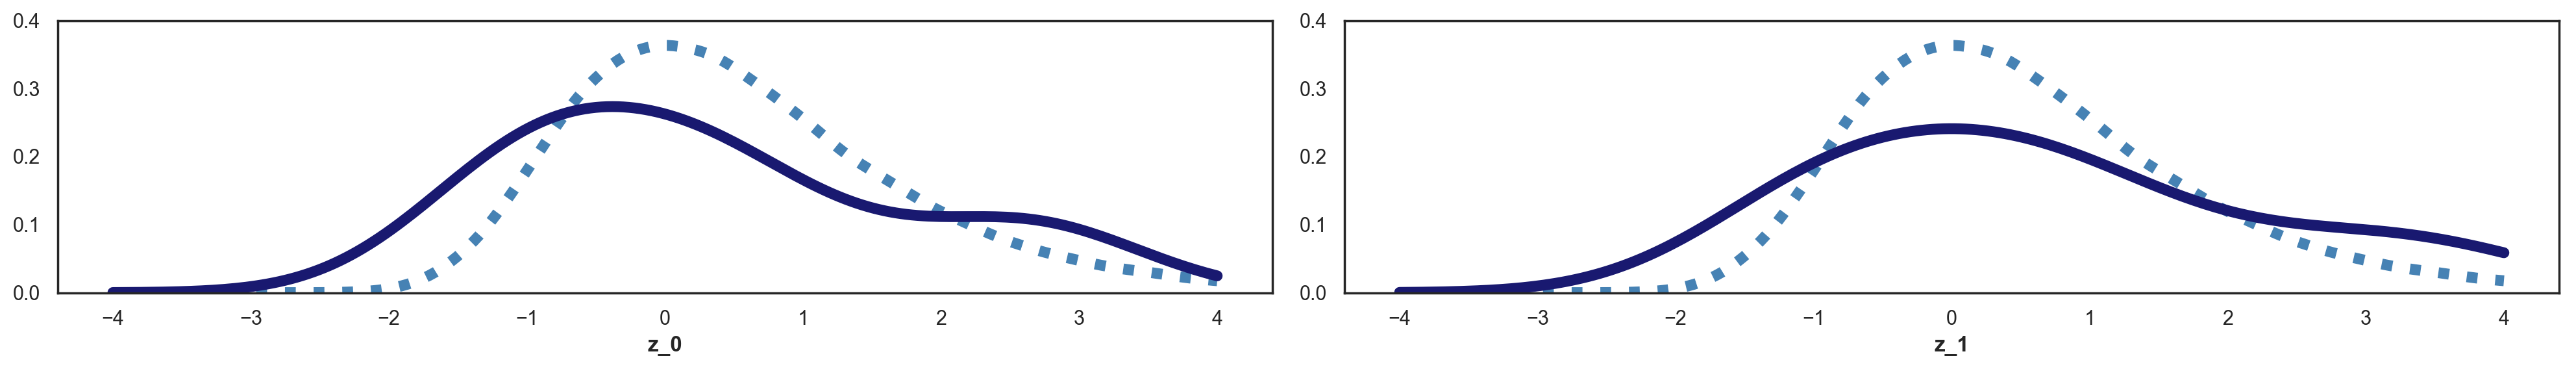

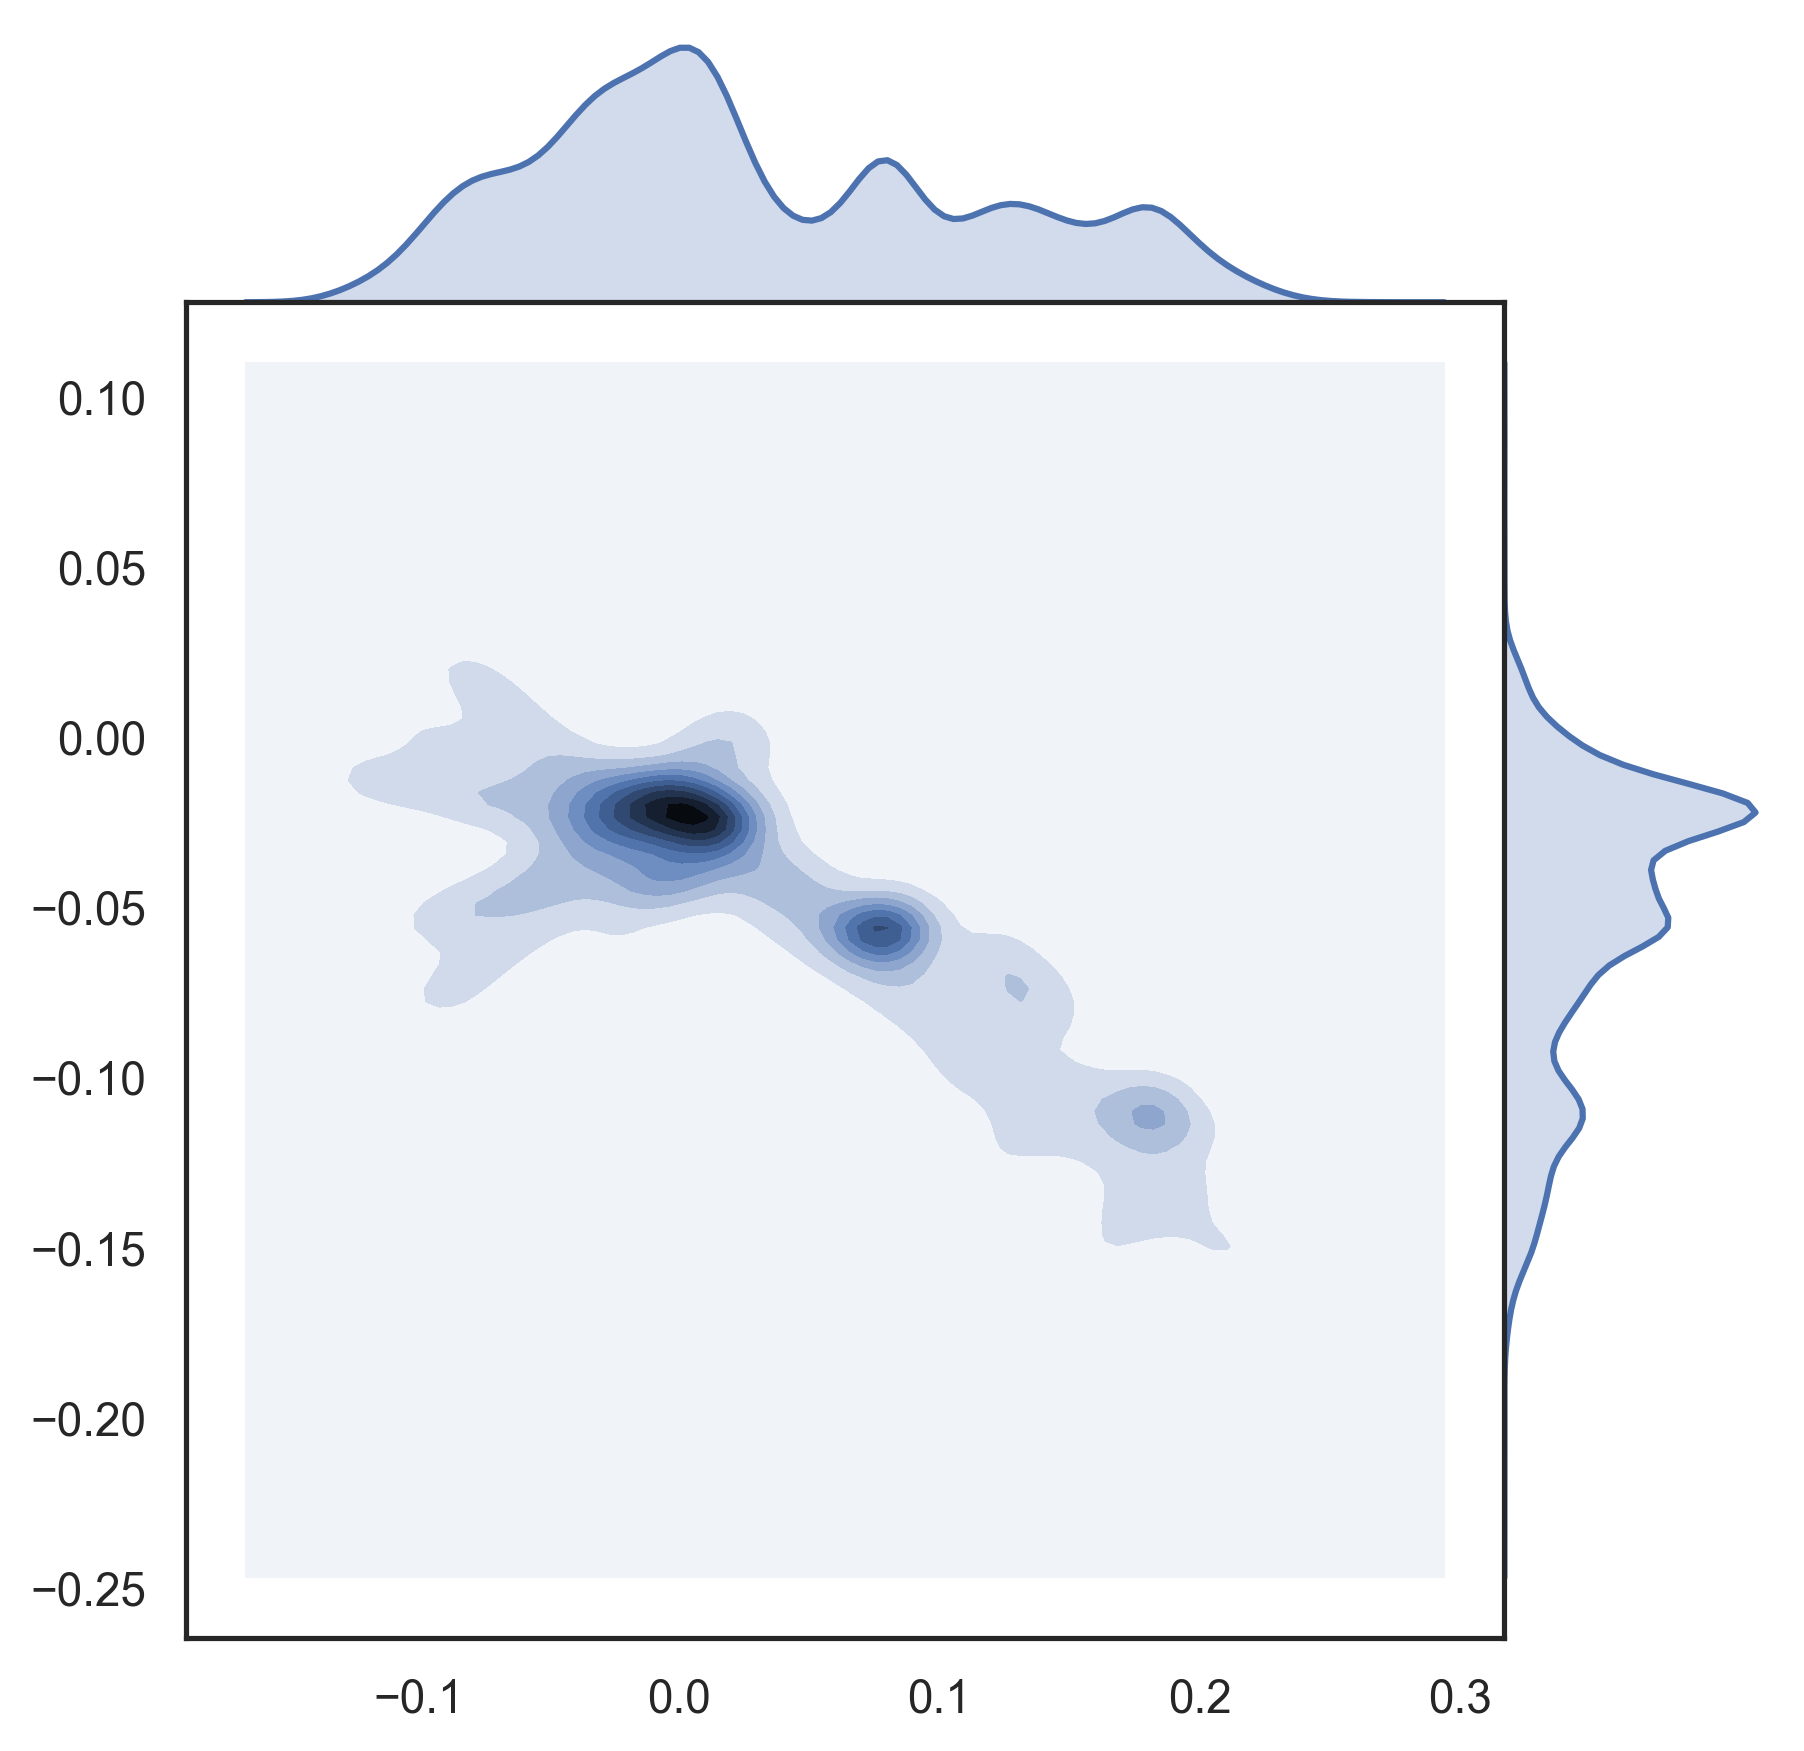

In [93]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

### Generate Single

latent dimensions: 2
nodes_n: 10
node attributes: [0.6779     0.4943622  0.4947934  0.5488713  0.4519794  0.32264942
 0.39420438 0.26215708 0.46294552 0.3019045 ]


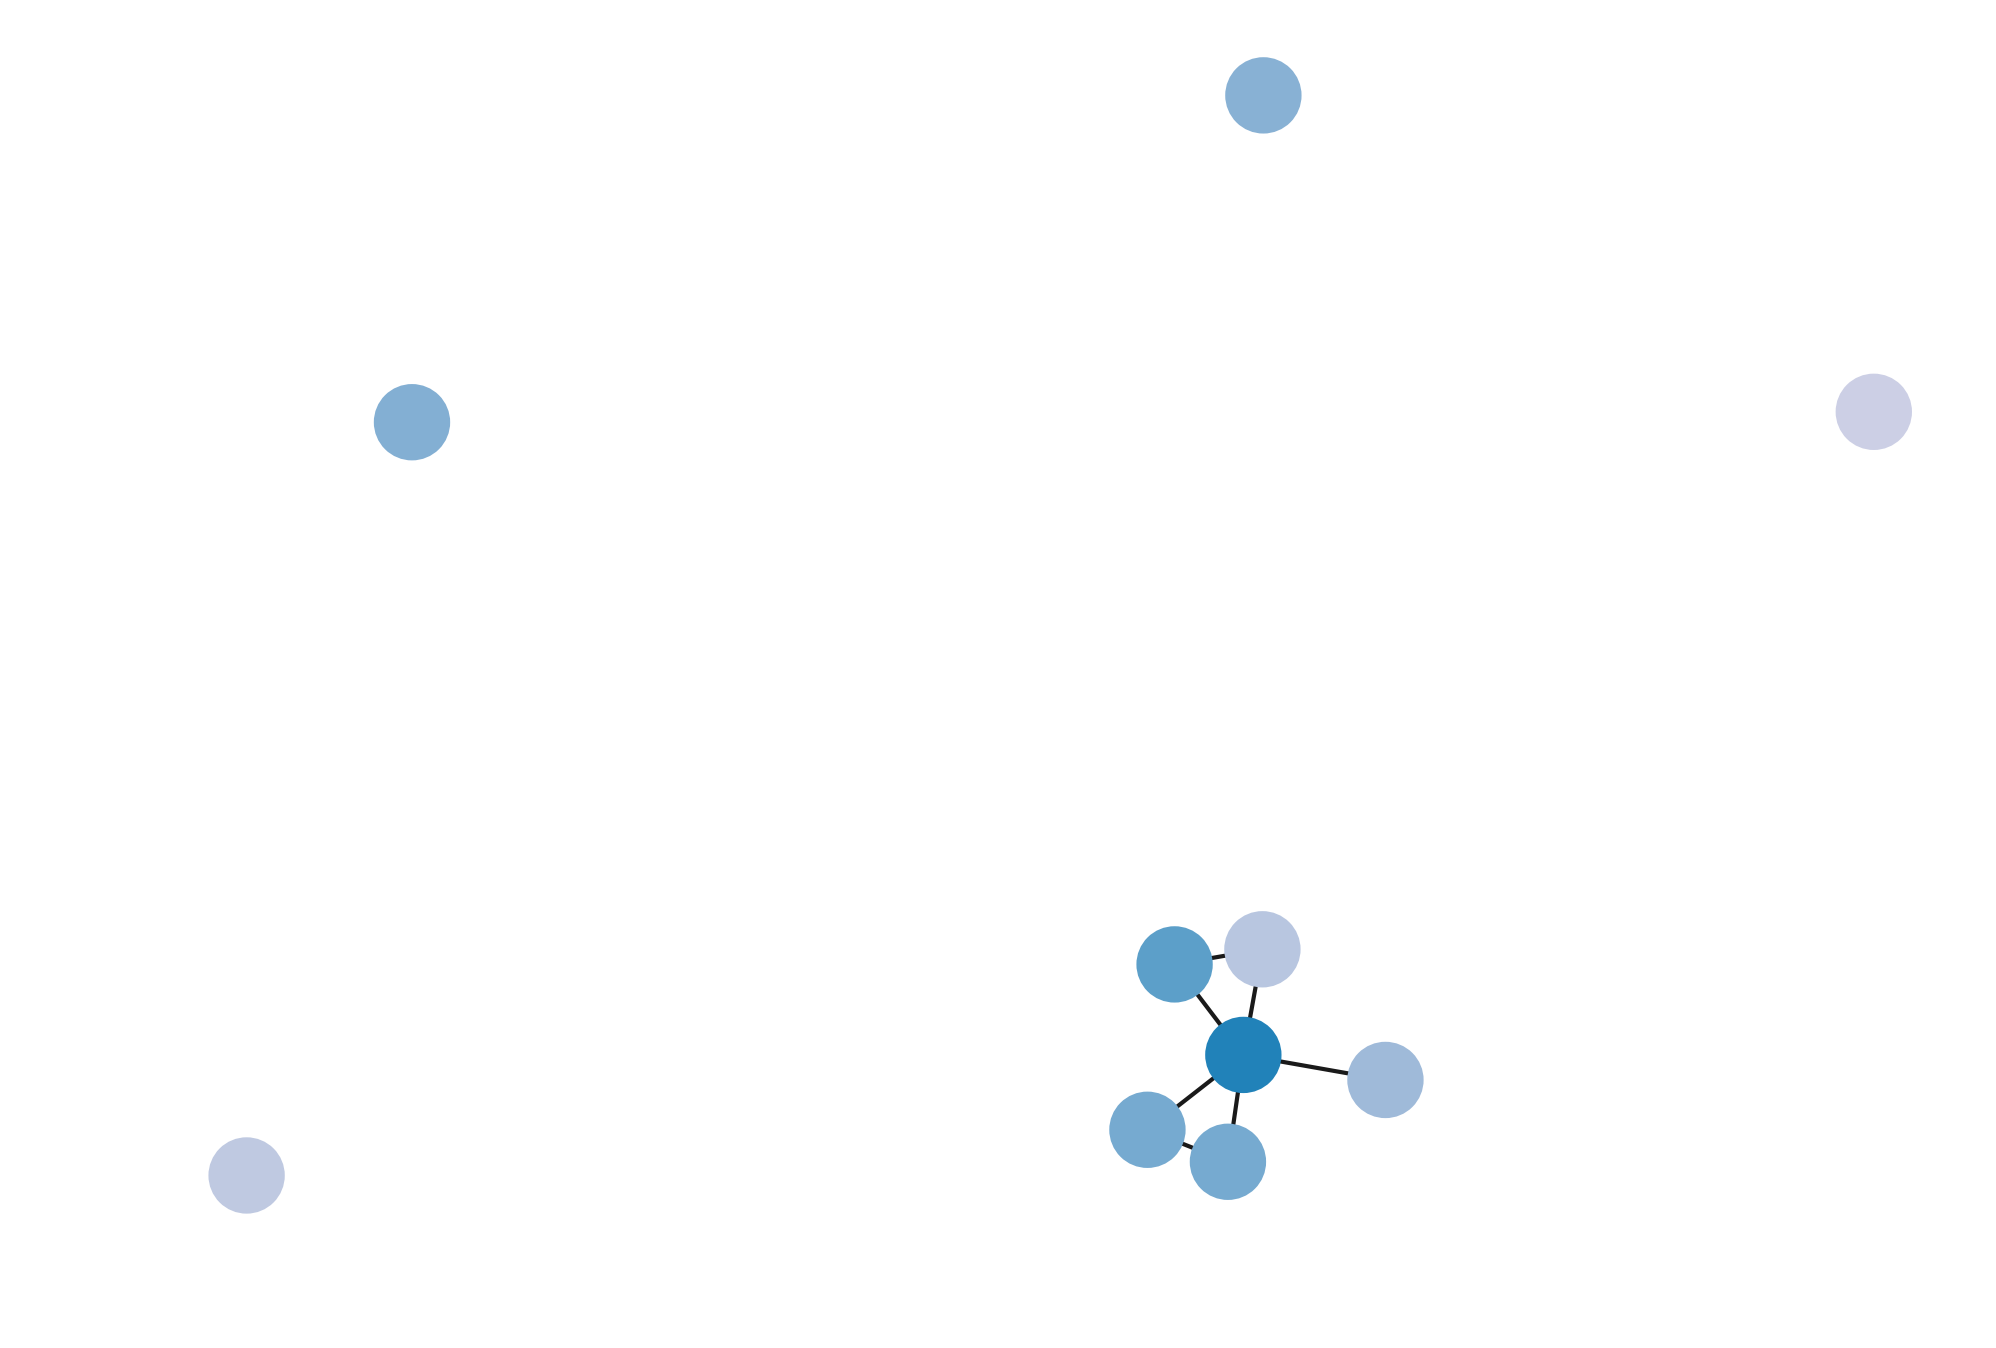

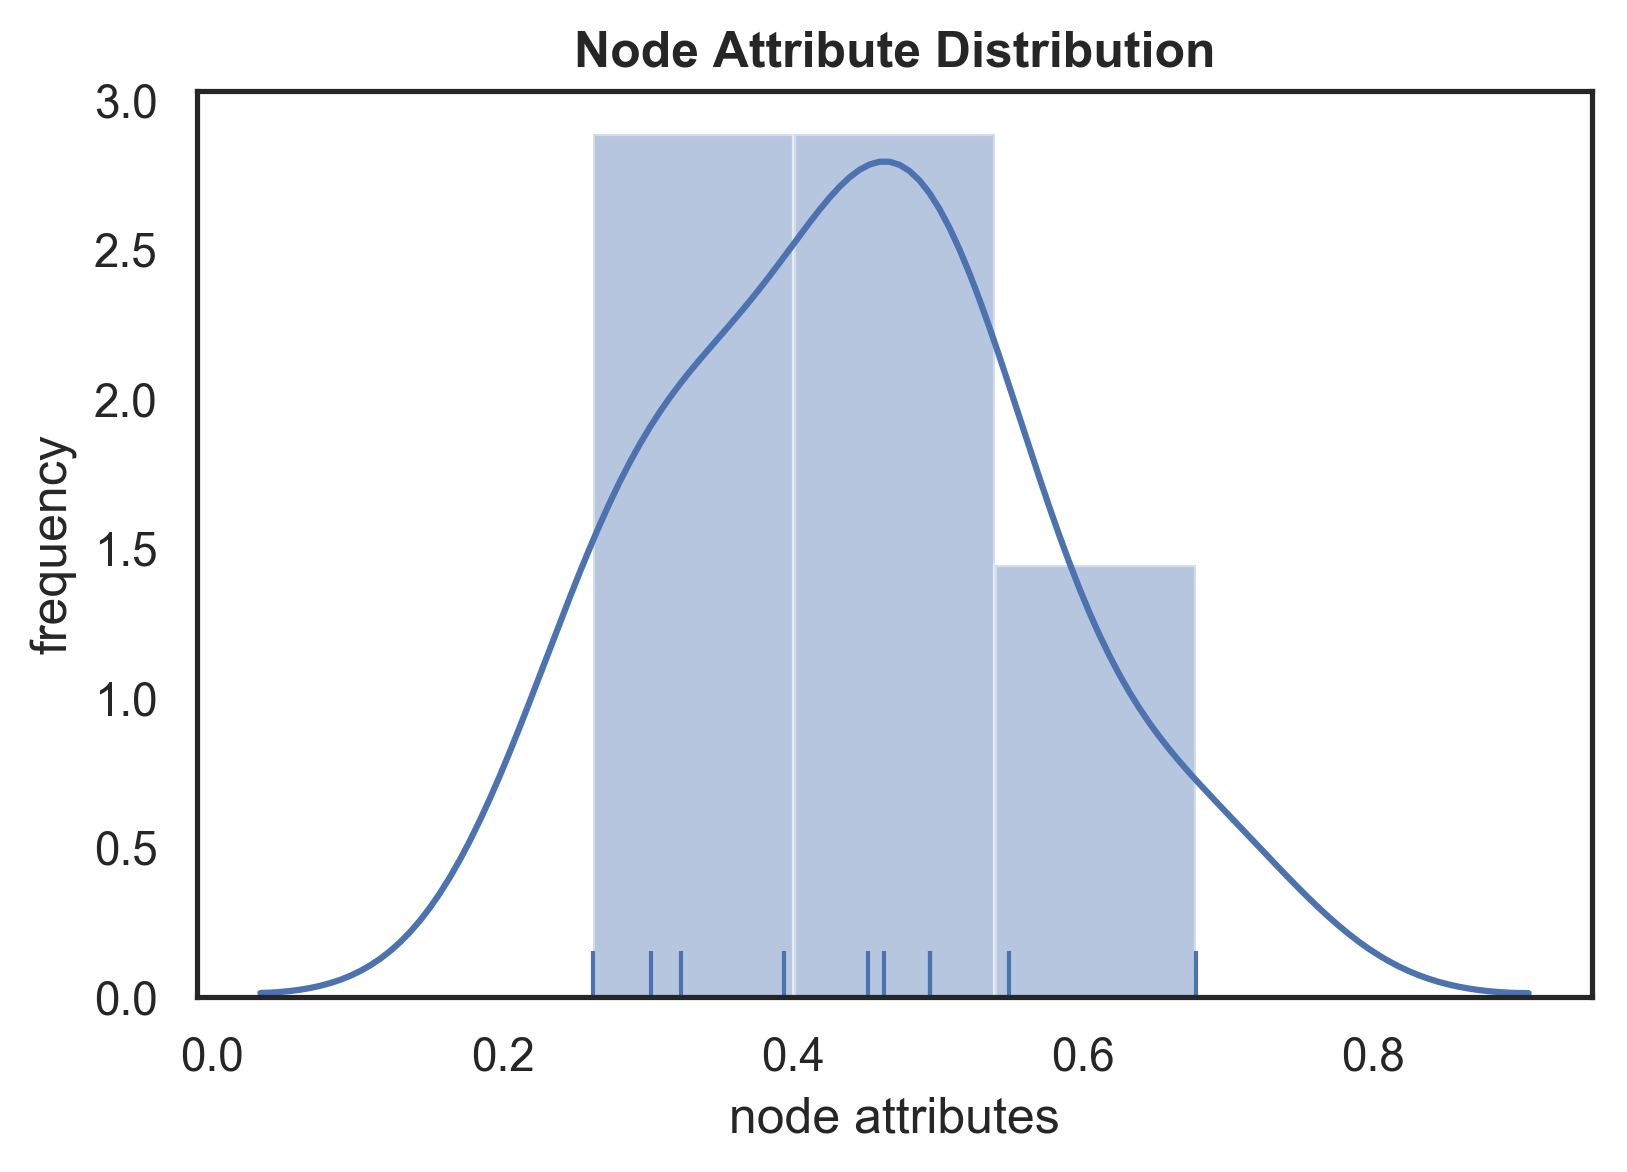

In [94]:
analyzeArgs = {"z": [0,1], "activations": [3,-2], "normalize_feature": False}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models, orig_cmap)

### Generate Manifold

In [79]:
## DECODER - Latent Space Interpolation____________________________



from networkx.generators import random_graphs
from networkx.generators import classic
import numpy as np

from matplotlib import pylab as plt
import os


def generate_features(dataArgs, g, n, p, yi_c):
                

    f = np.ones(n)  
    #f = f * np.random.rand()
    f = f * 0.5
    f = f + np.random.uniform(low=-0.1, high=0.1, size=(n))
    #f = f * yi_c
    f = np.reshape(f, (f.shape[-1],1))

    return f


def generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=128):
    print("latent dimensions:", modelArgs["latent_dim"])
    (encoder, decoder) = models

    (f_test, g_test) = data
    z_mean, z_log_var, _ = encoder.predict([f_test, g_test], batch_size=batch_size)

    ## Latent Space Dimension is 2 ______________________

    if modelArgs["latent_dim"] == 2:

        ## 1) create adjacency plots_______________________________________________

        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n, 3))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        if analyzeArgs["sample"] == "fake":
            grid_y = np.linspace(2, 16, analyzeArgs["size_of_manifold"], dtype = int)  ## revert
            grid_x = np.linspace(0.25, 0.88,analyzeArgs["size_of_manifold"])


            
        print(grid_y)
        ## 2) create graph plots_______________________________________________

        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8))
        # fig.subplots_adjust(hspace = .5, wspace=.001)

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):

                xi_value = xi ** analyzeArgs["act_scale"]
                yi_value = yi ** analyzeArgs["act_scale"]

                z_sample = np.array([[xi_value, yi_value]])
                [f_decoded, a_decoded] = decoder.predict(z_sample)
                
                
                xi_c = np.abs(xi + np.random.uniform(low=-0.10, high=0.10, size=1))
                yi_c = yi + int((np.random.randint(low=-1, high=1, size=1)))
                
                
                print("n",yi_c,"xi",xi_c)
                g = get_graph(yi_c, xi_c, draw = False)

                #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
                #plt.show()

                g, a = sort_adj(g)
                a_padded = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
                a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


                ## Generate / Load Node Features ______________________________________________
                f_unsqueezed = generate_features(dataArgs, g, yi_c, xi_c, yi_c)
                
                
                ## pad features with zeroes
                reconstructed_f = pad_attr(f_unsqueezed, dataArgs)  

                f = f_unsqueezed[:, 0]


                ## build fixed cmap
   
                if f_unsqueezed.shape[0] > 0:
                    fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
                else:
                    fixed_cmap = shiftedColorMap(orig_cmap, start=0.5, midpoint=0.5, stop=0.5, name='fixed')

                ## adjust colour reconstructed_a_padded according to features
                feature_a = a_padded
                feature_a = np.tile(feature_a[:, :, None], [1, 1, 3])  ## broadcast 1 channel to 3
                

                for node in range(0, yi_c):
                    color = np.asarray(fixed_cmap(f[node])[:3])
                    feature_a[node, :node + 1] = feature_a[node, :node + 1] * color
                    feature_a[:node, node] = feature_a[:node, node] * color
                    

                ## 1) create adjacency plots_____________________________________

                figure[i * n: (i + 1) * n, j * n: (j + 1) * n, :] = feature_a

                ## 2) create graph plot_____________________________

                ## reconstruct graph
                g = nx.from_numpy_matrix(a)

                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw_kamada_kawai(g, node_size=12, node_color=f, width=0.4, font_color='white', cmap=fixed_cmap)
                axs[i, j].set_axis_off()

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)

        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename)





latent dimensions: 2
[ 2  4  6  8 10 12 14 16]
n 2 xi [0.32854969]
n 1 xi [0.35930545]
n 2 xi [0.42290652]
n 2 xi [0.5198762]
n 2 xi [0.67358019]
n 2 xi [0.63067176]
n 2 xi [0.84817746]
n 1 xi [0.92323181]
n 4 xi [0.17232956]
n 3 xi [0.25639137]
n 4 xi [0.38321089]
n 4 xi [0.51715407]
n 4 xi [0.67709257]
n 3 xi [0.76983499]
n 3 xi [0.76330952]
n 3 xi [0.8913172]
n 5 xi [0.29938866]
n 5 xi [0.24541718]
n 6 xi [0.44896689]
n 5 xi [0.60218957]
n 5 xi [0.6398265]
n 5 xi [0.67253103]
n 5 xi [0.77252399]
n 6 xi [0.80502479]
n 7 xi [0.17030995]
n 7 xi [0.28426768]
n 7 xi [0.36516323]
n 7 xi [0.43418509]
n 8 xi [0.53327082]
n 7 xi [0.78904083]
n 7 xi [0.86447818]
n 8 xi [0.92324608]
n 10 xi [0.17426015]
n 10 xi [0.24365362]
n 10 xi [0.48899204]
n 9 xi [0.56969385]
n 10 xi [0.5727029]
n 10 xi [0.7947959]
n 9 xi [0.78850372]
n 9 xi [0.97359433]
n 11 xi [0.21799441]
n 12 xi [0.42268179]
n 12 xi [0.40818469]
n 12 xi [0.45007329]
n 11 xi [0.69383457]
n 11 xi [0.61403035]
n 11 xi [0.73971558]
n 12 x

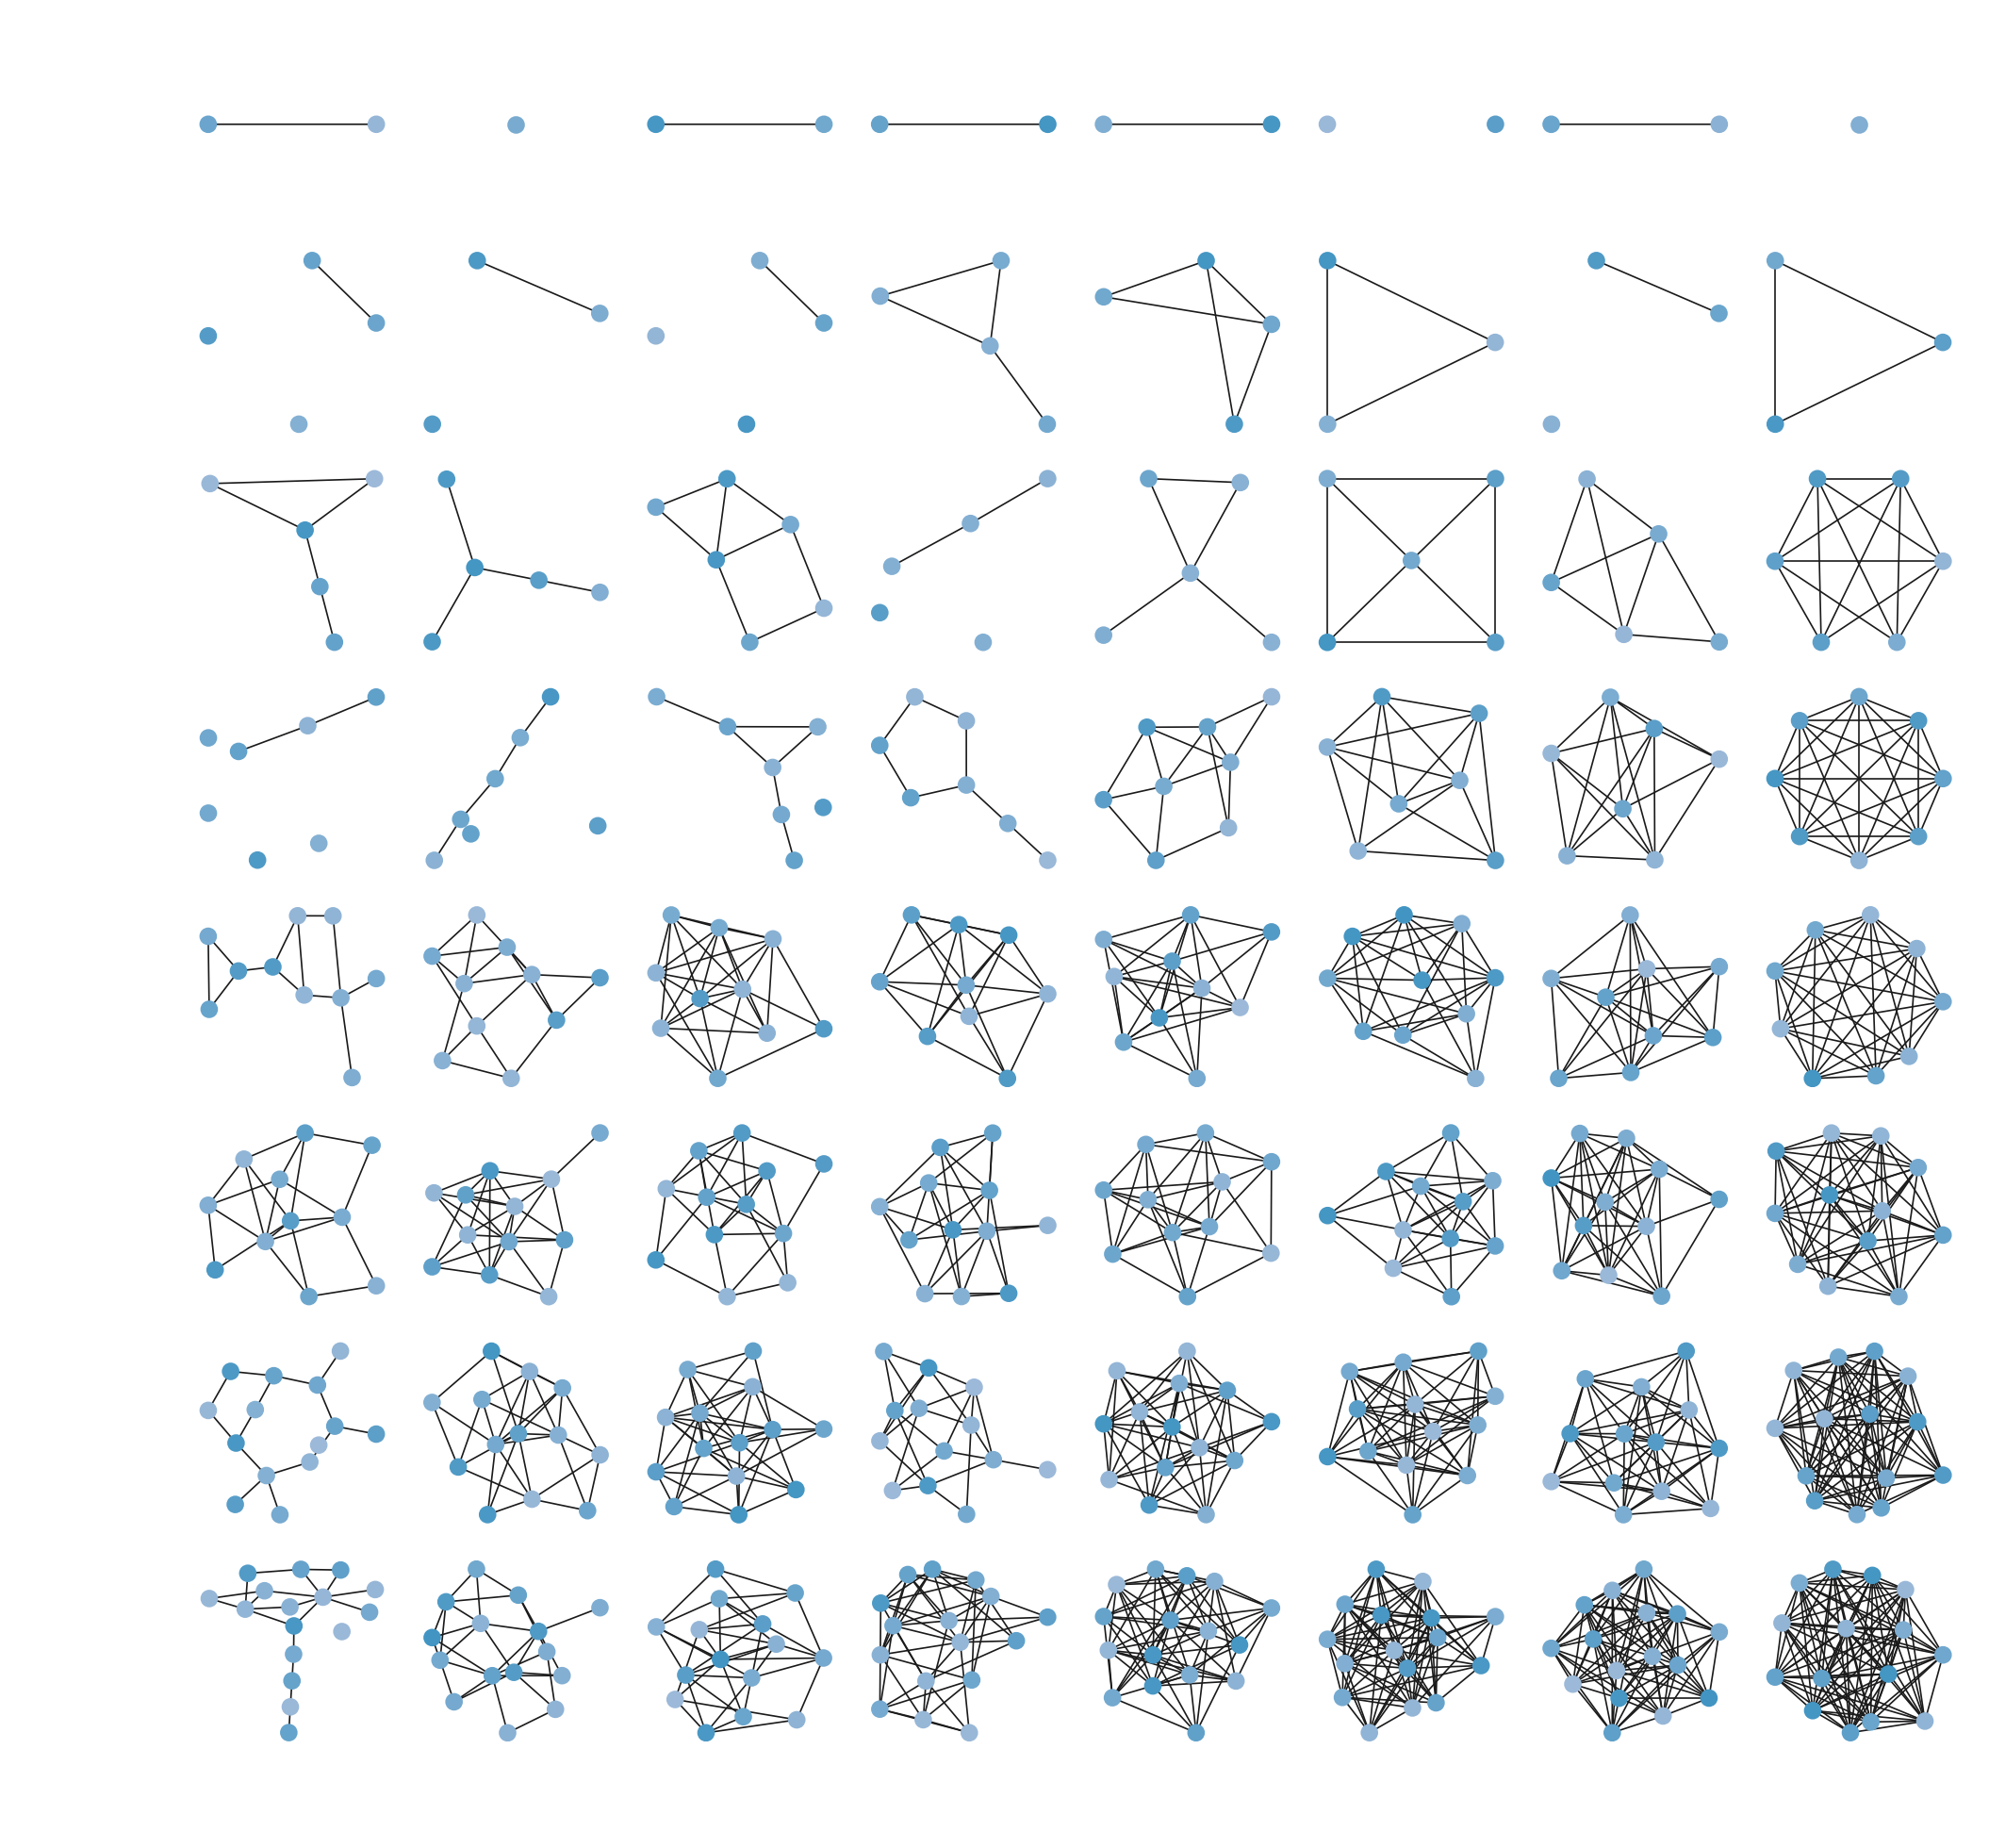

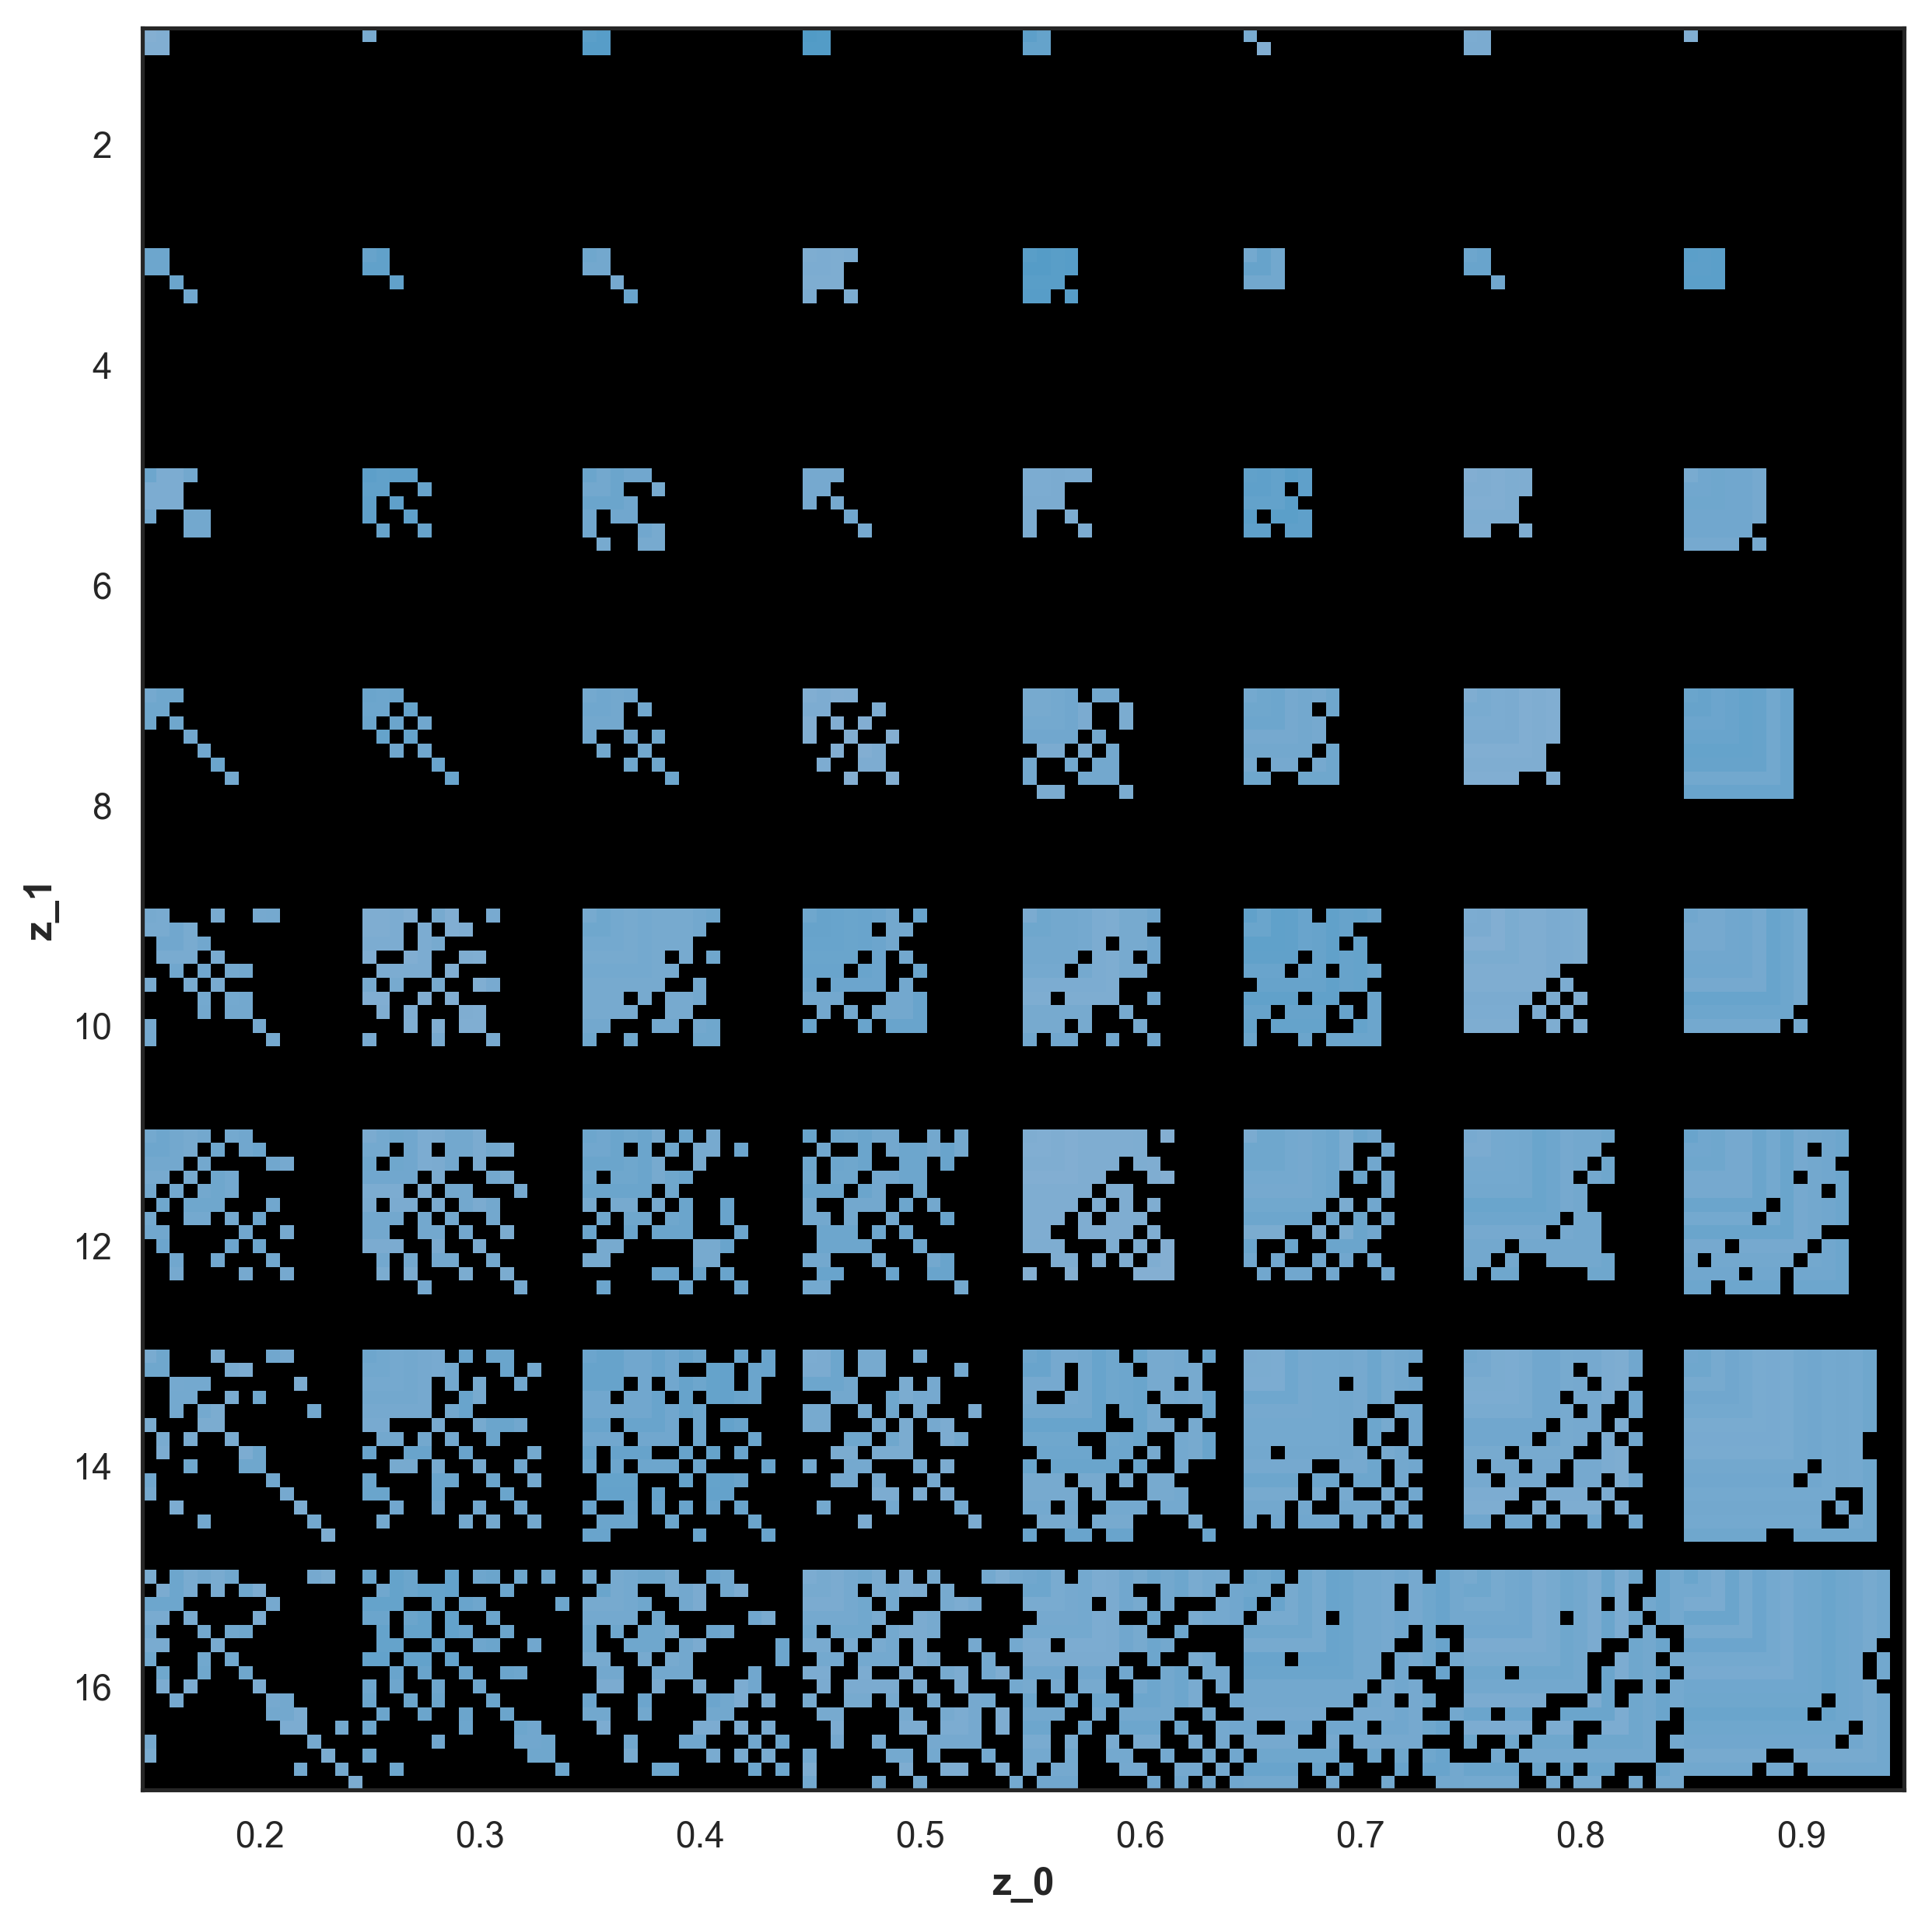

In [80]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "fake", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 8, "save_plots": False, "normalize_feature": False}
generate_manifold_features(analyzeArgs, modelArgs, dataArgs, models, data, orig_cmap, batch_size=trainArgs["batch_size"])

# Modification (Nullhypothesis Testing)

ground truth attribute dependence:  uniform
(20, 16) (20, 136)


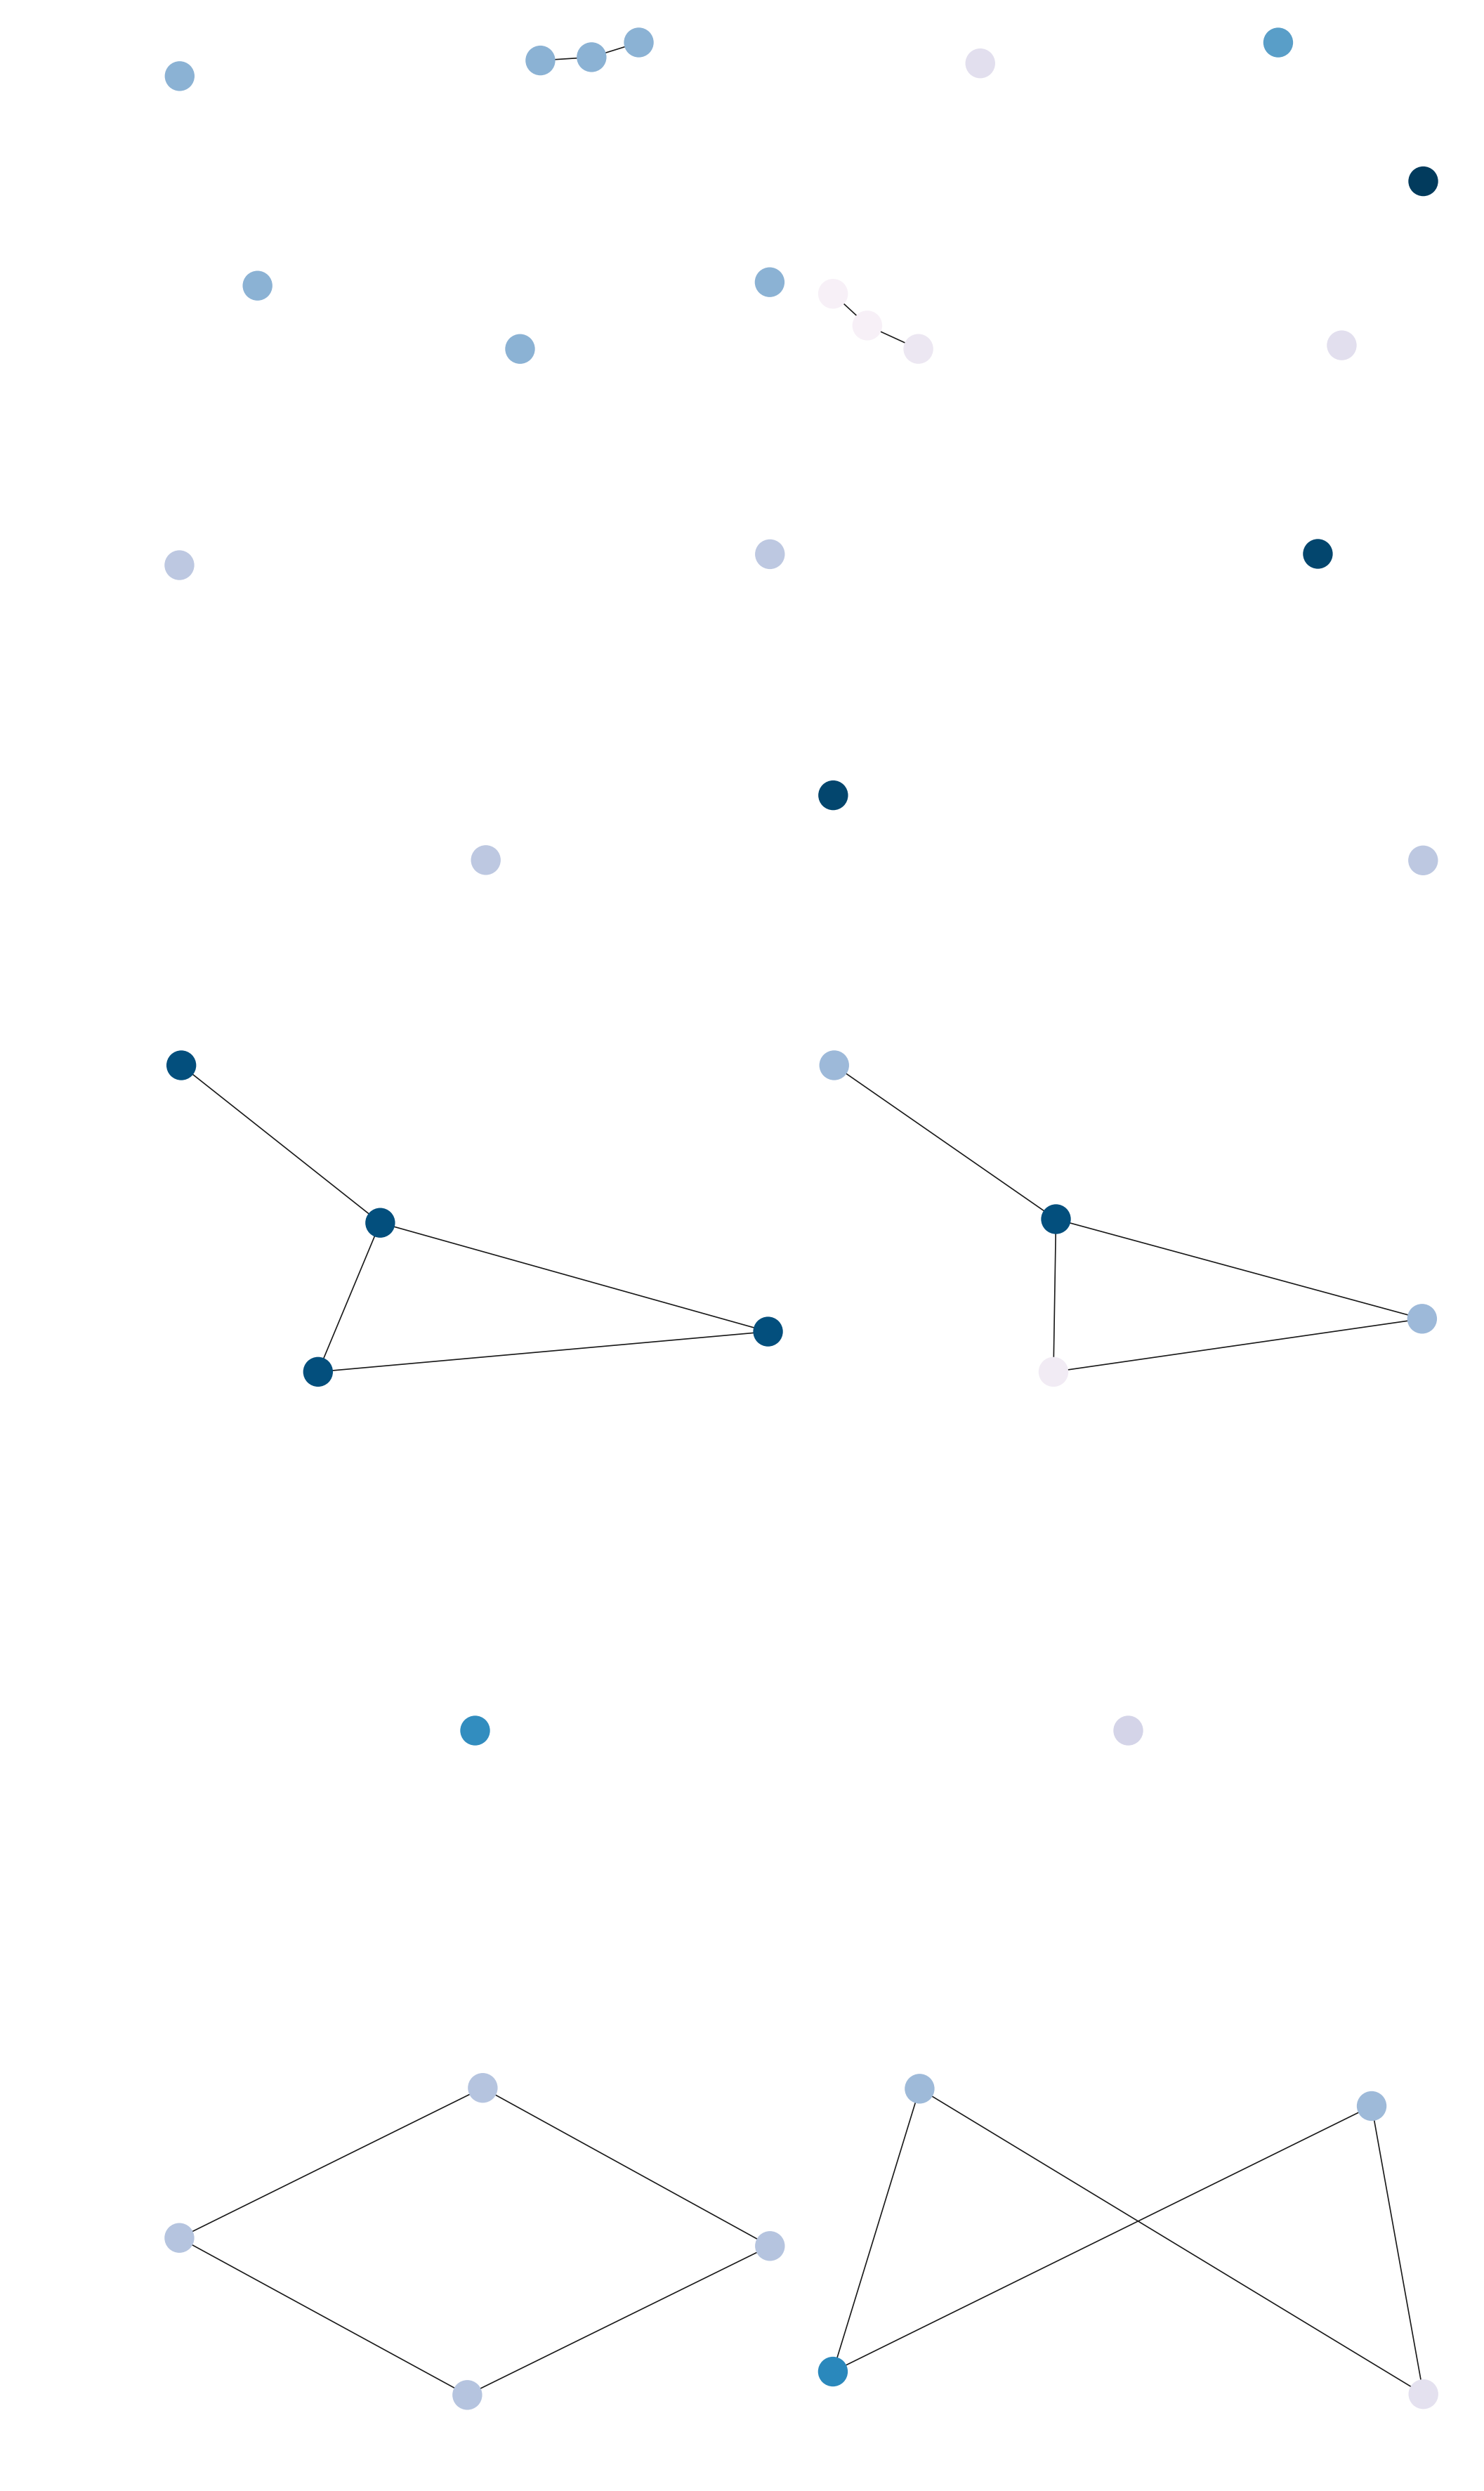


latent variable z_ 0
average_mean_shift: 0.0
average_wasserstein_dist: 0.022435009392460688


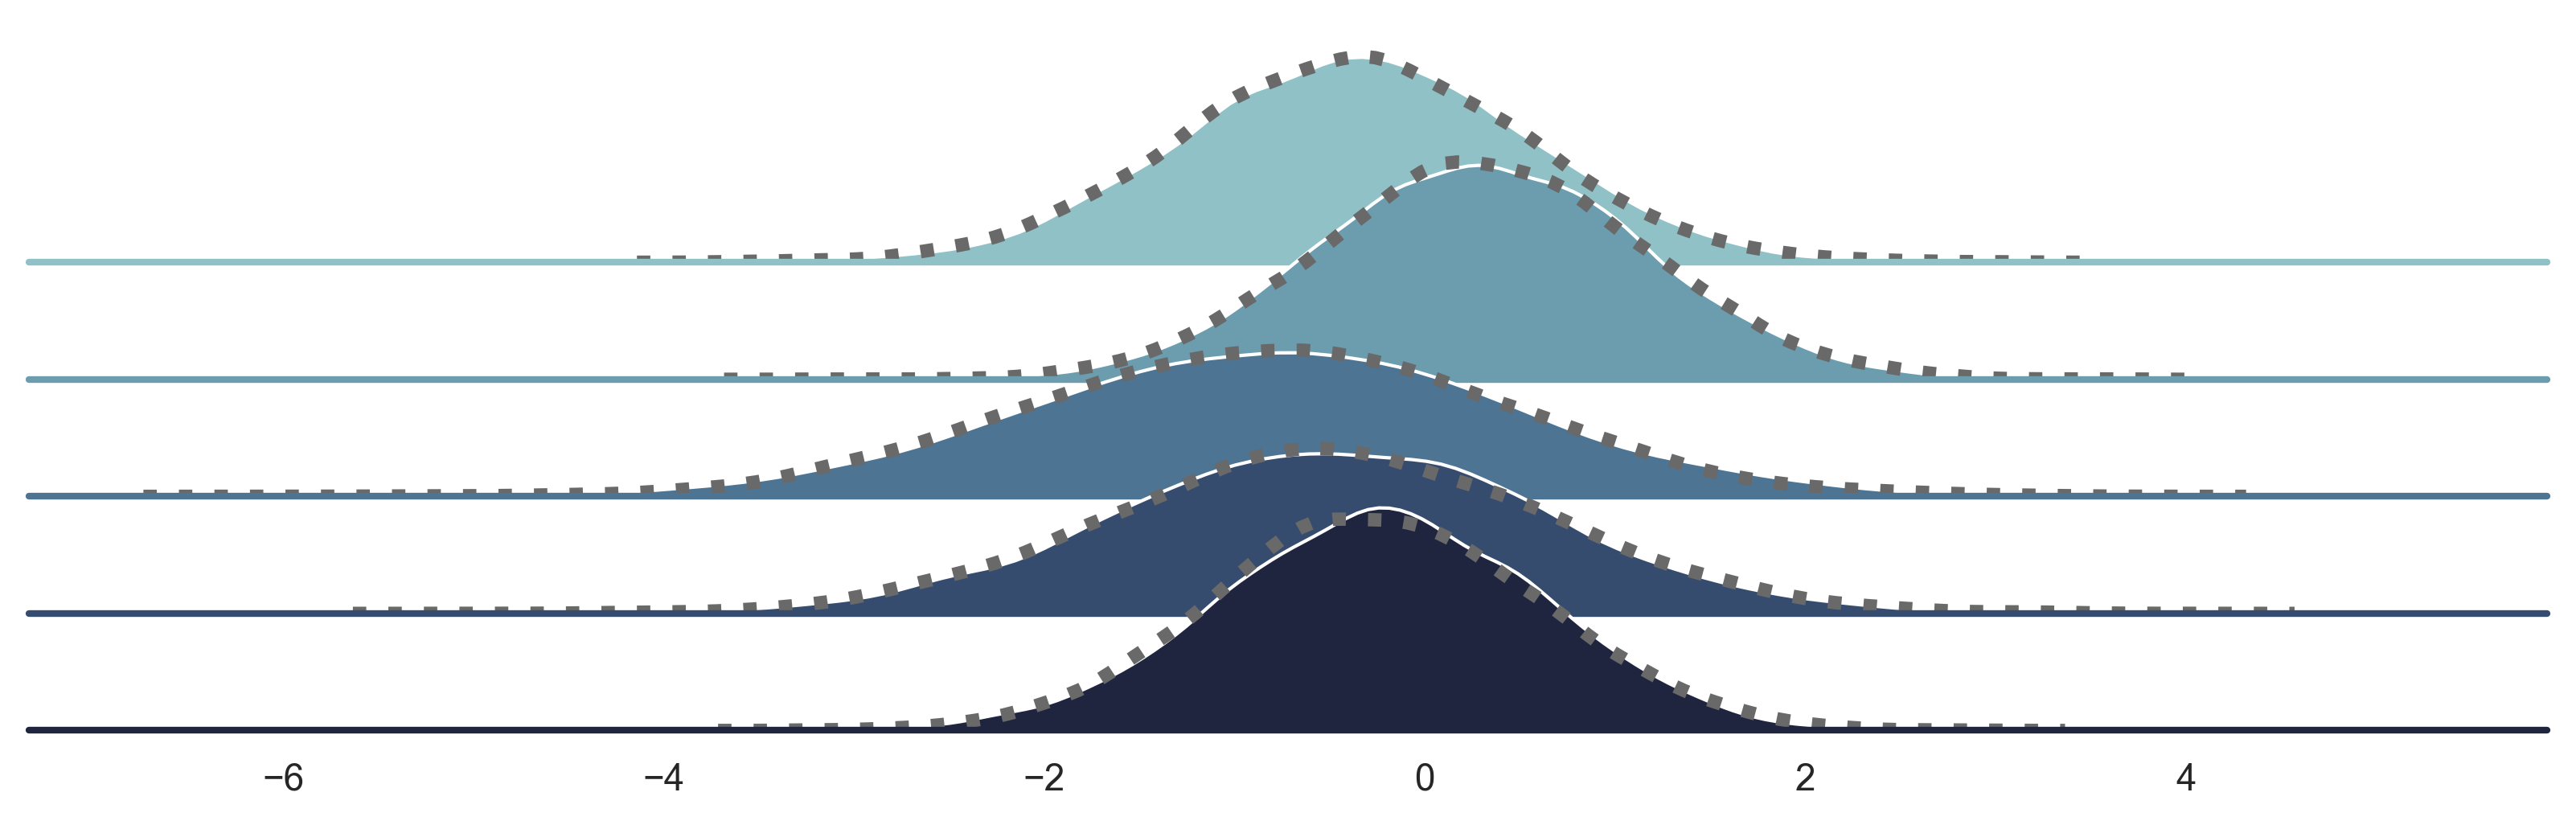


latent variable z_ 1
average_mean_shift: 0.0
average_wasserstein_dist: 0.015282890537735554


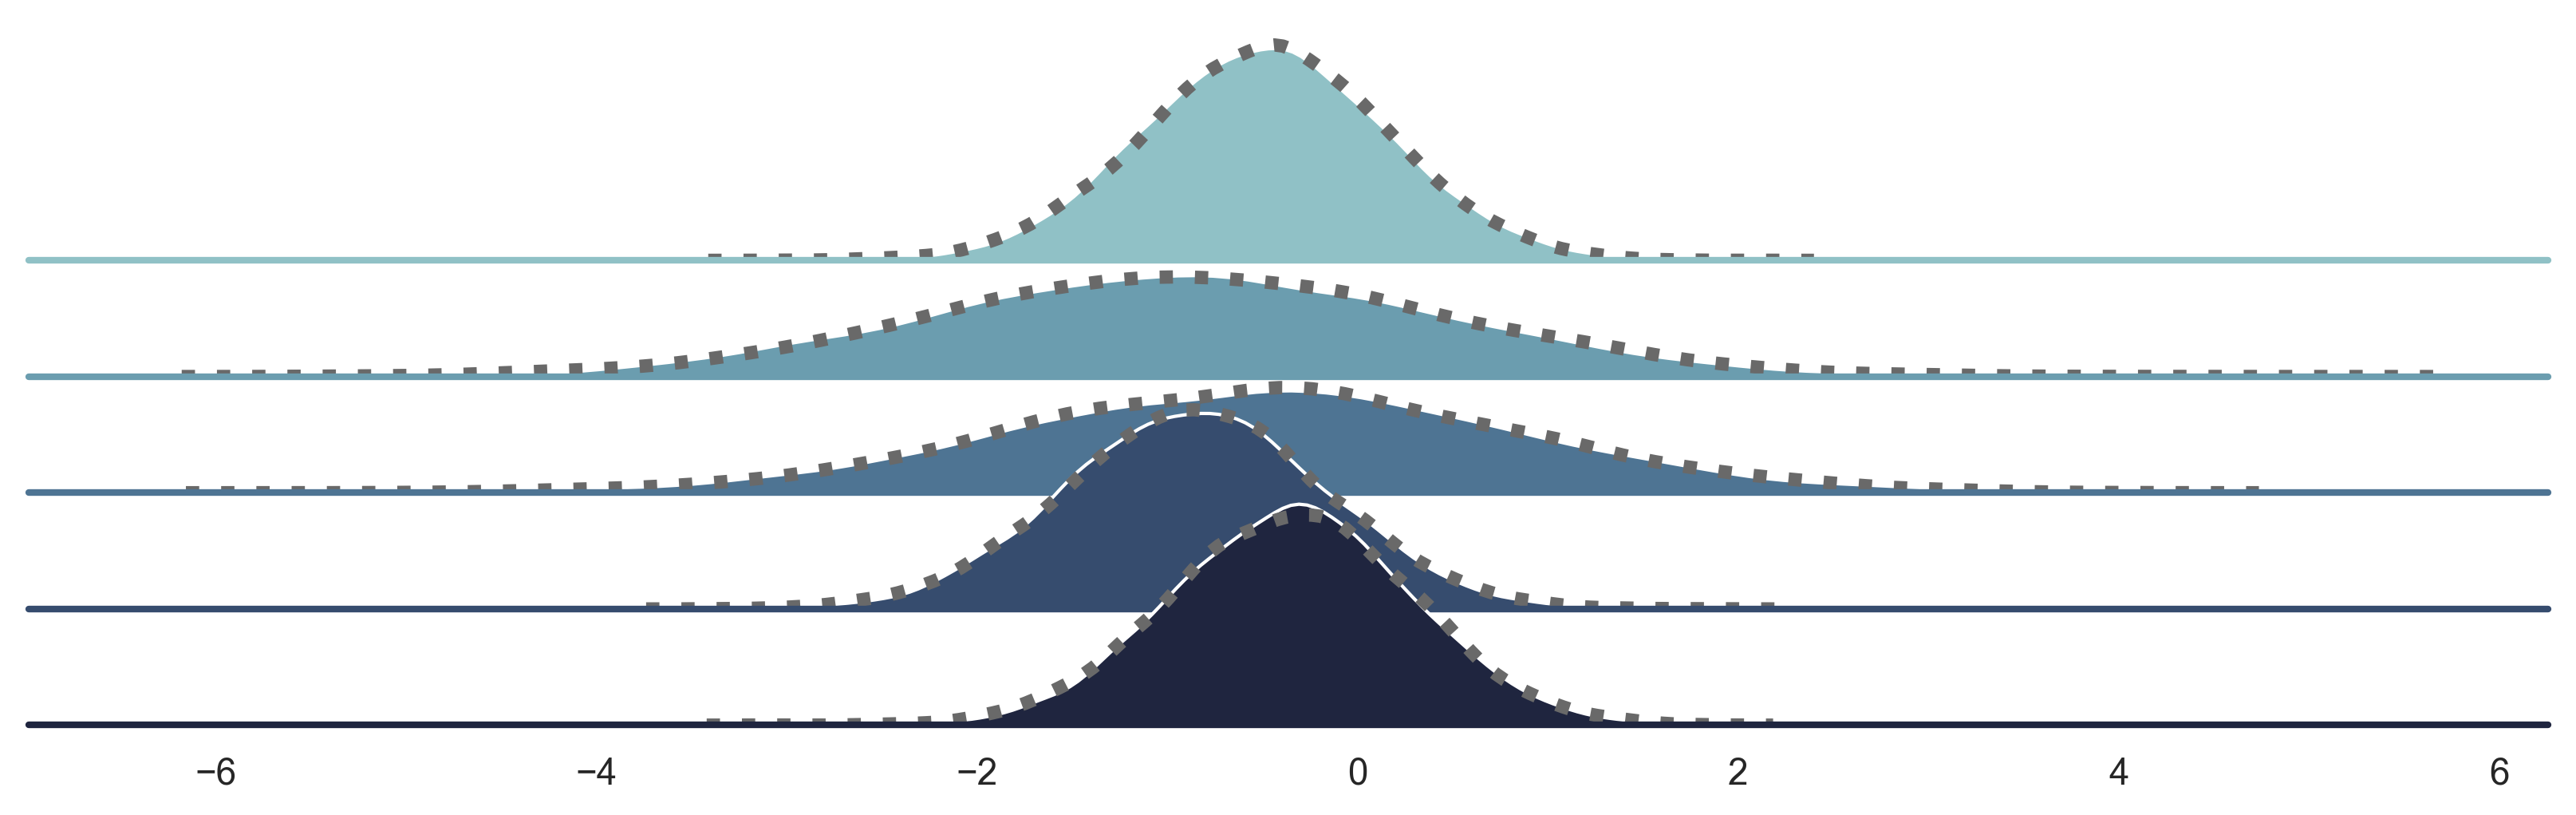

In [113]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    ## unpack models and data__________________________
    
    encoder, decoder = models  # trained models
    (F_org, A) = data
    
    print(F_org.shape, A.shape)

    F_mod = np.copy(F_org)
    
    for i, (f,a) in enumerate(zip(F_mod, A)):

        ## Generate Graph Type ______________________________________________
            
        reconstructed_a_padded = reconstruct_adjacency(a, dataArgs["clip"], dataArgs["diag_offset"])
        reconstructed_a, nodes_n = unpad_matrix(reconstructed_a_padded, dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
        
        f = np.reshape(f, (-1, 1))        
        f = unpad_attr(f, nodes_n, analyzeArgs, dataArgs)
        
        
        if analyzeArgs["f_variation"] == "random":
            for mod in range(0, int(analyzeArgs["mod_degree"] * nodes_n)):
                
                node = np.random.randint(low = 0, high = nodes_n, size = 2)
                rand_f = np.random.rand()
                f[node] = rand_f
        
        
        if analyzeArgs["f_variation"] == "shuffle":
            for mod in range(0, int(analyzeArgs["mod_degree"] * nodes_n)):
                swap = np.random.randint(low = 0, high = nodes_n, size = 2)
                temp = np.copy(f[swap[0]])
                f[swap[0]] = f[swap[1]]
                f[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":
    
            norm_std = analyzeArgs["mod_degree"]
            norm_mean = np.mean(f) 
            
            for i in range(0,len(f)):
                
                if f[i] > norm_mean:
                    f[i] = f[i] - (norm_std * (np.abs(f[i] - norm_mean)))
                else:
                    f[i] = f[i] + (norm_std * (np.abs(f[i] - norm_mean )))
                    
                    
        elif analyzeArgs["f_variation"] == "uniform":
    
            f = np.ones(f.shape[0]) * analyzeArgs["mod_degree"]
            f = np.reshape(f, (f.shape[-1],1))
        
        
        ## pad features with zeroes
        f = np.reshape(f,(-1,1))
        f = pad_attr(f, dataArgs)
        
        
    fig, axs = plt.subplots(analyzeArgs["n_graphs"],2, figsize=(8, 15), facecolor='w', edgecolor='k', dpi = 300)
    fig.subplots_adjust(hspace = .5, wspace=.001)

    for i in range(0, analyzeArgs["n_graphs"]):
        
        ## reconstruct upper triangular adjacency matrix
        reconstructed_a = reconstruct_adjacency(A[i], dataArgs["clip"], dataArgs["diag_offset"])
        reconstructed_a, nodes_n = unpad_matrix(reconstructed_a, dataArgs["diag_value"], 0.1, dataArgs["fix_n"])
        
        ## reconstruct graph
        reconstructed_a = np.reshape(reconstructed_a, (reconstructed_a.shape[0], reconstructed_a.shape[1]))
        g = nx.from_numpy_matrix(reconstructed_a)
        
        
        ## original features
        f_org = np.reshape(F_org[i], (-1,1))
        reconstructed_f_org = unpad_attr(f_org, nodes_n, analyzeArgs, dataArgs)
        
        if reconstructed_f_org.shape[0] > 0:
            fixed_cmap = shiftedColorMap(orig_cmap, start=min(reconstructed_f_org), midpoint=0.5, stop=max(reconstructed_f_org),name='fixed')
        else:
            fixed_cmap = shiftedColorMap(orig_cmap, start=0.5, midpoint=0.5, stop=0.5, name='fixed')
        
        plt.sca(axs[i, 0])
        nx.draw(g, node_size=84, node_color=reconstructed_f_org, width=0.4, font_color='white', cmap=fixed_cmap)
        axs[i, 0].set_axis_off()
        
        

        ## modified features
        f_mod = np.reshape(F_mod[i], (-1,1))
        reconstructed_f_mod = unpad_attr(f_mod, nodes_n, analyzeArgs, dataArgs)
        
        if reconstructed_f_mod.shape[0] > 0:
            fixed_cmap = shiftedColorMap(orig_cmap, start=min(reconstructed_f_mod), midpoint=0.5, stop=max(reconstructed_f_mod),name='fixed')
        else:
            fixed_cmap = shiftedColorMap(orig_cmap, start=0.5, midpoint=0.5, stop=0.5, name='fixed')
        
        plt.sca(axs[i, 1])
        nx.draw(g, node_size=84, node_color=reconstructed_f_mod, width=0.4, font_color='white', cmap=fixed_cmap, dpi = 300)
        axs[i, 1].set_axis_off()
        
    
    plt.show()
    
    
    
    
    ## ENCODER - 2D Digit Classes ______________________________________________
        
    z_mean, z_log_var, _ = encoder.predict([F_org, A], batch_size = batch_size)
    z_mean_mod, z_log_var_mod, _ = encoder.predict([F_mod, A], batch_size = batch_size)
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features
    
    ## Feature Change ____________________________ 
        
    z_mean = np.random.uniform(low=-1.0, high=0.4, size=(analyzeArgs["n_graphs"], modelArgs["latent_dim"]))    
    z_mean_mod = z_mean
    z_var = np.random.uniform(low=0.6, high=1.4, size=(analyzeArgs["n_graphs"], modelArgs["latent_dim"]))
    z_var_mod = z_var
    
    for latent_i in range(0, modelArgs["latent_dim"]):   
        
        Normal_org = np.array([])
        Normal_mod = np.array([])
        total_mean_shift = 0
        total_emd = 0
                
        for graph_i in range(0, analyzeArgs["n_graphs"]):

            ## compute shift and EMD
            mean_shift = np.abs(z_mean[graph_i, latent_i] - z_mean_mod[graph_i, latent_i])
            total_mean_shift += mean_shift

            #x = np.linspace(z_mean[graph_i, latent_i] - 3*math.sqrt(z_var[graph_i, latent_i]), z_mean[graph_i, latent_i] + 3*math.sqrt(z_var[graph_i, latent_i]), 1000)
            #y = stats.norm.pdf(x, z_mean[graph_i, latent_i], math.sqrt(z_var[graph_i, latent_i]))
            #plt.plot(x, y, color='midnightblue', linestyle='solid', linewidth=4)
            normal_org = np.random.normal(z_mean[graph_i, latent_i], z_var[graph_i, latent_i], analyzeArgs["norm_samples"])
            Normal_org = np.hstack((Normal_org, normal_org))
            #sns.distplot(normal_org)
            
            #x_mod = np.linspace(z_mean_mod[graph_i, latent_i] - 3*math.sqrt(z_var_mod[graph_i, latent_i]), z_mean_mod[graph_i, latent_i] + 3*math.sqrt(z_var_mod[graph_i, latent_i]), 1000)
            #y_mod = stats.norm.pdf(x_mod, z_mean_mod[graph_i, latent_i], math.sqrt(z_var_mod[graph_i, latent_i]))
            #plt.plot(x_mod, y_mod, color='steelblue', linestyle='dashed', linewidth=4)
            normal_mod = np.random.normal(z_mean_mod[graph_i, latent_i], z_var_mod[graph_i, latent_i], analyzeArgs["norm_samples"])
            Normal_mod = np.hstack((Normal_mod, normal_mod))
            #sns.distplot(normal_mod)
            
            #plt.xlabel('latent posterior z_' + str(latent_i), fontweight = "bold")
            #plt.annotate("mean shift:" + str(mean_shift) , xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')
            total_emd += wasserstein_distance(normal_org, normal_mod)

        sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

        # Create the data
        #g = np.tile(list("ABCDEFGHIJ"), 1000) # size 1000
        x = np.arange(0, analyzeArgs["n_graphs"], 1)
        x = np.repeat(x, analyzeArgs["norm_samples"])
        df = pd.DataFrame(dict(org=Normal_org, mod=Normal_mod, x=x))

        #m = df.g.map(ord)  ## offset
        #df["x"] += m

        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(analyzeArgs["n_graphs"], rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="x", hue="x", aspect=15, height=.75, palette=pal)

        # Draw the densities in a few steps
        #g.map(sns.kdeplot, "org", clip_on=False, shade=True, color="red", alpha=1.0, lw=1.5, bw=.2)
        #g.map(sns.kdeplot, "org", clip_on=False, shade=True, alpha=1.0, lw=2, bw=.2)
        g.map(sns.distplot, "org", hist = False, kde = True, kde_kws={'linewidth': 0, "shade": True, "alpha": 1.0})
        #g.map(sns.kdeplot, "mod", clip_on=False, shade=True, alpha=1.0, lw=1.5, bw=.2)
        #g.map(sns.kdeplot, "mod", clip_on=False, shade=False, color="orange", alpha=1.0, lw=2, bw=.2)
        g.map(sns.distplot, "mod", color="dimgrey", hist = False, kde = True, bins = 1000, kde_kws={'linestyle':':', 'linewidth': 4})
        g.map(plt.axhline, y=0, lw=2, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)

        #g.map(label, "x")

        # Set the subplots to overlap
        g.fig.subplots_adjust(hspace=-.5)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[])
        g.despine(bottom=True, left=True)
        
        print("\nlatent variable z_", latent_i)
        print("average_mean_shift:", total_mean_shift / analyzeArgs["n_graphs"])
        print("average_wasserstein_dist:", total_emd / analyzeArgs["n_graphs"])
        
        plt.pause(0.05)


        
## PLOT RESULTS ________________________________________
print("ground truth attribute dependence: ", dataArgs["feature_dependence"])
analyzeArgs = {"mod_degree": 1.0, "n_graphs": 5, "f_variation": "random", "norm_samples": 10000, "metric": "none", "normalize_feature": False}
modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Latent Variable Correlation


In [68]:
def feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    
    ## unpack models and data__________________________
    
    encoder, decoder = models  # trained models
    #F, [A_fil, A] = data
    
    ## generate input network _________________________
    
    g = get_graph(analyzeArgs["n"], analyzeArgs["p"], draw = False) 
    g, a = sort_adj(g)
    a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
    a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
    A = np.reshape(a_transformed, (1, *a_transformed.shape))
    A = np.tile(A, (analyzeArgs["mod_steps"],1))
        
    f = generate_features(dataArgs, g, analyzeArgs["n"], analyzeArgs["p"]) 
    print("original features:\n", f)
    
    F_mod = np.zeros((analyzeArgs["mod_steps"], dataArgs["n_max"], dataArgs["n_features"]))
        
                 
    ## Modify Features__________________________________
                 
    mod_degree = np.linspace(0,dataArgs["n_max"],analyzeArgs["mod_steps"], dtype = int) 
    
    for i, mod in enumerate(mod_degree):
        
        f_mod = np.copy(f)

        if analyzeArgs["f_variation"] == "random":
            for m in range(0, mod):
                swap = np.random.randint(low = 0, high = f_mod.shape[0], size = 2)
                temp = f[swap[0]]
                f_mod[swap[0]] = f_mod[swap[1]]
                f_mod[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":

            mod_ratio = mod / max(mod_degree)
            norm_mean = np.mean(f)

            for i in range(0,len(f_mod)):

                if f_mod[i] > norm_mean:
                    f_mod[i] = f_mod[i] - (mod_ratio * (np.abs(f_mod[i] - norm_mean)))
                else:
                    f_mod[i] = f_mod[i] + (mod_ratio * (np.abs(f_mod[i] - norm_mean )))


        elif analyzeArgs["f_variation"] == "uniform":

            f_mod = np.ones(f_mod.shape[0]) * (mod / max(mod_degree))
            f_mod = np.reshape(f_mod, (f_mod.shape[-1],1))

        ## pad features with zeroes
        f_mod = pad_attr(f_mod, dataArgs)
        F_mod[i] = f_mod    
        

    ## ENCODER ______________________________________________
    z_mean, _, _ = encoder.predict([np.squeeze(F_mod), A], batch_size = batch_size)


    ## Measure the Mutual Information Gap ____________________________________________
    if analyzeArgs["metric"] == "mig":
        mig = compute_mig(mod_degree, np.squeeze(z_mean))
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    ## Visualize Latent Variables x Feature Change ____________________________

    fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= 1, figsize=(10,20), dpi = 300)


    for latent_z, row in enumerate(ax):        

            y = z_mean[:,latent_z]
            x = mod_degree / max(mod_degree)
            sns.regplot(x, y, color="steelblue", ax=row, ci = None, x_ci='sd', x_estimator=np.mean)
            row.set_ylim([np.mean(z_mean[:,latent_z]) -0.1, np.mean(z_mean[:,latent_z]) + 0.1])

            ## compute correlation and standardized covariance
            corr = round(pearsonr(x,y)[0],3)
            cov = round(np.cov(x, y)[0][1]/max(x),3)
            std = round(np.std(y),3)
            row.annotate("corr:"+str(corr)+", std:"+str(std), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points', fontweight='bold')

            

    ## add row and column titles _____________________

    rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
    cols = [t for t in ["node attribute modification percentage"]]

    for axis, col in zip(ax, cols):
        axis.set_title(col, fontweight='bold')

    for axis, row in zip(ax, rows):
        axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


        
## PLOT RESULTS ________________________________________

dataArgs["feature_dependence"] = "degree"  #"degree", "random", "p"
analyzeArgs = {"n": 5, "p": 0.4, "mod_steps": 1000, "f_variation": "random", "metric": "none", "normalize_feature": False}
feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

TypeError: generate_features() missing 1 required positional argument: 'yi_c'